In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from HelperFunctions import timestmphm2sec

In [3]:
pathDetour = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/200/ITERS/it.0/0.drt_detours_drt.csv"
pathTrips = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/200/ITERS/it.0/0.drt_trips_drt.csv"
pathOccs = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/200/ITERS/it.0/0.drt_occupancy_time_profiles_drt.txt"
detour_df = pd.read_csv(pathDetour, delimiter=";")
trip_df = pd.read_csv(pathTrips, delimiter=";")
occ_df = pd.read_csv(pathOccs, delimiter="\t")
occ_df["time"] = occ_df["time"].apply(timestmphm2sec)

<IPython.core.display.Javascript object>


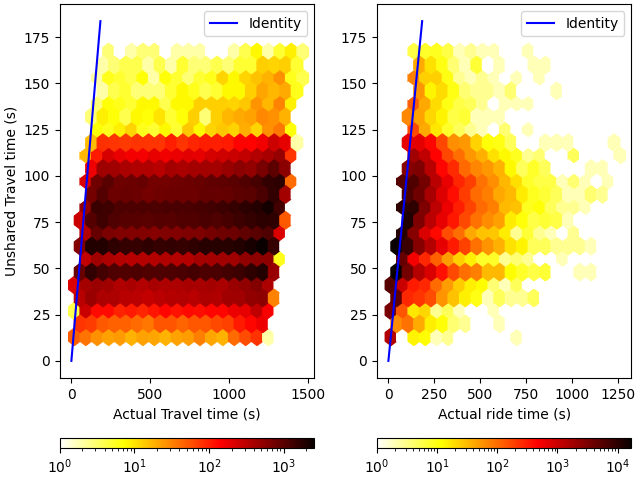

In [4]:
%matplotlib notebook
from matplotlib.colors import LogNorm

fig, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True)
# fig = plt.figure(constrained_layout=True)
# gs = fig.add_gridspec(12, 2)
# ax = fig.add_subplot(gs[:10, 0])
# ax2 = fig.add_subplot(gs[:10, 1])
# cax = fig.add_subplot(gs[11,0])
# cax2 = fig.add_subplot(gs[11,1])

xmin = detour_df["time"].min()
xmax = detour_df["time"].max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 50)
# ax.scatter(detour_df["time"], detour_df["unsharedTime"], alpha=0.5, s=1, label='Data')
# im = ax.hexbin(detour_df["time"], detour_df["unsharedTime"], gridsize=(nx, ny), cmap='hot_r', extent=(xmin,xmax,ymin,ymax))
im = ax.hexbin(
    detour_df["time"],
    detour_df["unsharedTime"],
    gridsize=20,
    cmap="hot_r",
    extent=(xmin, xmax, ymin, ymax),
    norm=LogNorm(),
)
# ax.plot([-100, xlim[1]], [-100, xlim[1]], c="r", label='Identity')
ax.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity")
ax.set_xlabel("Actual Travel time (s)")
ax.set_ylabel("Unshared Travel time (s)")
# fig.colorbar(im, cax=cax, orientation='horizontal')
fig.colorbar(im, ax=ax, location="bottom")
ax.legend()

ride_time = detour_df["time"] - trip_df["waitTime"]
xmin = ride_time.min()
xmax = ride_time.max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
# print(xmin, xmax, ymin, ymax)
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 10)
im2 = ax2.hexbin(
    ride_time,
    detour_df["unsharedTime"],
    #     gridsize=(nx, ny),
    gridsize=20,
    cmap="hot_r",
    norm=LogNorm(),
    #     extent=(xmin, xmax, ymin, ymax),
)
# ax2.scatter(ride_time, detour_df["unsharedTime"], s=0.01, label='data')
# xlim = ax2.get_xlim()
# ax2.plot([-100, xlim[1]], [-100, xlim[1]], c="r", label="Identity")
ax2.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity")
ax2.set_xlabel("Actual ride time (s)")
fig.colorbar(im2, ax=ax2, location="bottom")
# ax2.set_ylabel('Unshared ride time (s)')
ax2.legend()


# fig.savefig('TimeDetourComparison.png', dpi=200)
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.stackplot(
    occ_df["time"],
    occ_df[["4 pax", "3 pax", "2 pax", "1 pax", "0 pax", "STAY"]].T,
    labels=[
        "4 passengers",
        "3 passengers",
        "2 passengers",
        "1 passengers",
        "0 passengers",
        "staying",
    ],
    colors=["b", "g", "r", "c", "m", "grey"],
)

ax.legend(bbox_to_anchor=(0, -0.2, 1, 0.1), loc="upper left", ncol=3)
fig.tight_layout()

# fig.savefig('DrtOccupancy_180_wDiag')

plt.show()